<div style="text-align: center;padding-top:10px;padding-bottom:10px">
    <a href="https://geostatisticslessons.com/" target="_blank" style="color:#93c6c7" >
    <img src="https://geostatisticslessons.com/favicon-96x96.png" alt="Geostatistics Lessons Link" style="width:100px">
    </a>
</div>

<div style="text-align: center">
    <h1 style="color:#00797C;padding-bottom:0px">The Pairwise Relative Variogram</h1>
    <h2 style="color:#00797C;padding-bottom:20px">A Companion Notebook to Geostatistics Lessons</h2>    
</div>

<p class="author" style="padding: 0;"><center><b>Haoze Zhang and Ryan Barnett</b></center></p>
<p class="date" style="padding: 0;"><center><b>July 15, 2024</b></center></p>

---

# Outline

The following notebook provides a demonstration of the theory presented in [The Pairwise Relative Variogram ](https://geostatisticslessons.com/lessons/pairwiserelative) notebook. The following steps are used for comparing the traditional variogram against alternatives that are popular for managing the proportional effect: 

1. **Introductory example**
    - Generate an exhaustive reference grid that is then sampled in clustered manner
    - Compare the experimental traditional variogram (+alternatives) of the data against the true reference variogram of the grid
2. **Testing of other continuity cases**
    - Steps that are slowly developed in the introductory example are wrapped into a single function
    - This function is iteratively called with reference grids of varying continuity to see if observations from Section 1 generalize.


The presented workflow may be extended to represent other deposits.

---

Import required packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rmsp
rmsp.activate()

License cleq45ynq00htgomxajqjmhjb checked out by cleq3u00o0001mxb8e7xapuw4 to cleu6f8al000bs23fjbek6ljd expires in 4 minutes. RMSP is up to date!


Setup some plotting/global parameters:

In [2]:
rmsp.GlobalParams['core.enable_beta'] = True
var = rmsp.Variable('var').set_variable_params(
    clim=(0.1, 10), cmap_log=True)

---
# Introductory Example

To begin, we will step slowly through the following workflow in this section:
1. Generate a 'true' reference grid of a lognormal variable
1. Sample that variable with additional density in high grade areas
1. Compare the true traditional variogram (based on the grid) against the variogram of the data (traditional + alternatives)

The next section will repeat these steps in a more effienct manner, iterating over differing variogram shapes and nuggets to inspect associated variation in performance of the variogram alternatives.

## Generate reference model

Create a variogram model for input to simulation:

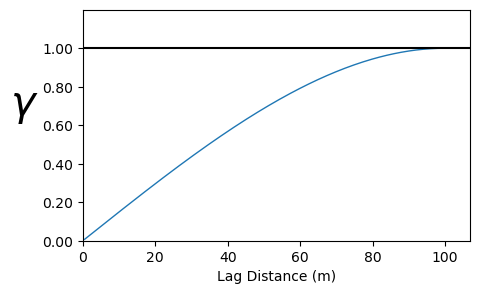

In [3]:
variomod = rmsp.VarioModel.from_params(
    nugget=0.0, num_struct=1, shapes='spherical', var_contribs=1,
    angles=[0, 0, 0], ranges=[100, 100, 1])
_ = variomod.plot(figsize=(5, 3))

Simulate a Gaussian deviate before transforming to a lognormal distribution:

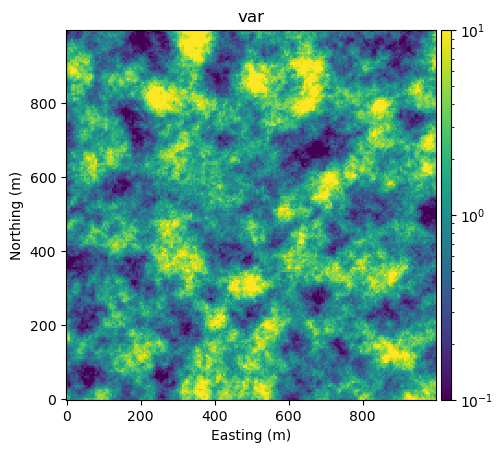

In [4]:
grid = rmsp.GridData(
    griddef=rmsp.GridDef(0, 0, 0, 0, 200, 200, 1, 5, 5, 1, 'full'))
grid['var'] = rmsp.Simulator().uncond_simulate(grid, variomod, seed=51232)
grid['var'] = np.exp(grid['var'])
_ = grid.sectionplot('var')

## Calculate reference variogram

We will now calculate the variogram of the exhaustive grid, which is treated as the underlying true continuity (note that it will differ from the variogram model used in simulation due to the lognormal transform).

Begin by defining `lags` that we will use for both gridded and data variogram calculations. 5m lags are used for precision in the clustered areas, before reverting to wider 10m lags beyond 50m distance. This is more important for the data variogram calculations due to associated spacing regimes, but also speeds up the gridded variogram calculation. When these `lags` are input to the gridded variogram search (`gridsearch`), the associated tolerances are ignored (unlike the data variogram calculation that follows).

In [5]:
lags = [rmsp.Lags(5, 5, 10), rmsp.Lags(10, 5, 5)]
grid_search = rmsp.ExpVarioSearchGrid(0.0, 0.0, lags)

Calculate and plot the variogram:

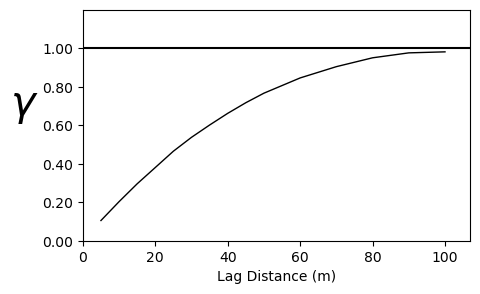

In [6]:
vario_ref = rmsp.ExpVario().calculate_griddata(grid, 'var', grid_search)

refpars = dict(label='reference', ms=0, ls='-', c='k')
_ = vario_ref.plot(**refpars, figsize=(5, 3))

## Clustered sampling of high grades

The exhaustive truth is now sampled, where additional density is placed in high grade areas similar to common practice. Note that the nature of the sampling is not essential to understanding and wrapped in a function for later use. A histogram shows the skewed nature of the sample data, following the lognormal variable that it is sampling.

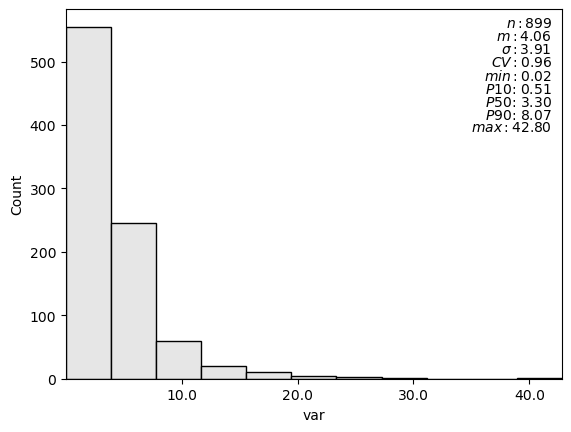

In [7]:
def sample_with_high_grade_clustering(grid):
    probs = np.concatenate((np.linspace(0, 0.8, 300),
                            np.linspace(0.8, 1, 600)))
    grades = grid['var'].quantile(probs, interpolation='lower')
    return grid[grid['var'].isin(grades)].to_pointdata()

data = sample_with_high_grade_clustering(grid)
_ = data.histplot('var')

Compare the data against the exhaustive reference grid in plan-section:

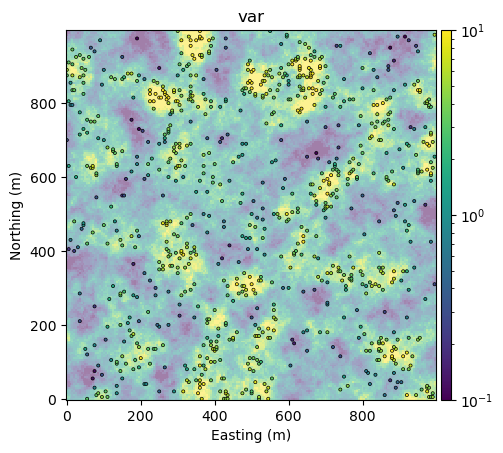

In [8]:
ax = grid.sectionplot(var, alpha=0.5)[1]
_ = data.sectionplot_draw(ax, 'var', s=5, ec='k')

## Calculate the data variogram (traditional + alternatives):

Setup experimental variogram search:

In [9]:
search = rmsp.ExpVarioSearch(0, 0, lags, azmtol=90, incltol=90)

List variogram types that we will test: `traditional`, flipped correlogram (`correlogram_f`), back-transformed normal scores (`backns`), and pairwise relative (`pairwiserel`).

In [10]:
variotypes = ['traditional', 'correlogram_f', 'backns', 'pairwiserel']

A normal score transform must be defined to facilicate `backns`:

In [11]:
nstrans = rmsp.NSTransformer(warn_no_wt=False).fit(data['var'])

Iterate over the variogram types and compare against the reference truth. Observe that the pairwise relative and back-tranformed normal scores significantly outperform the traditional and correlogram in all cases. Generality of this outcome will be examined in the next section.

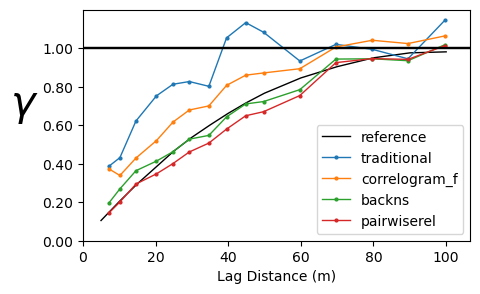

In [12]:
fig, ax = vario_ref.plot(**refpars, figsize=(5, 3))
for variotype in variotypes:
    expvario = rmsp.ExpVario(variotype=variotype)
    expvario.calculate(data, 'var', search, nstransformer=nstrans)
    expvario.plot(ax=ax, label=variotype, ls='-', ms=2)

_ = ax.legend()

---
# Test Other Continuity Cases

Setup a function for compact execution of the workflow that was developed in the prior section, but allowing for differing continuities to be inspected.

In [13]:
def generate_reference(name, vario_pars):
    """Wrap steps from the prior section in a function for iteration

    Global variables defined in the prior section are applied.
    The only thing changing per function call is the specified
    variogram parameters and associated name.
    """
    # Simulate and sample reference for the specified vario
    vario_mod = rmsp.VarioModel.from_params(**vario_pars)
    grid['var'] = np.exp(rmsp.Simulator().uncond_simulate(
        grid, vario_mod, seed=51232))
    data = sample_with_high_grade_clustering(grid)
    # Initialize figure with a sectionplot of the data/grid
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    grid.sectionplot(var, alpha=0.5, ax=axes[0])
    _ = data.sectionplot_draw(axes[0], 'var', s=5, ec='k')
    data.sectionplot('var', s=5, title='', ax=axes[0])
    # Gridded reference vaiogram calculation and plotting
    vario_ref = rmsp.ExpVario().calculate_griddata(grid, 'var', search)
    vario_ref.plot(**refpars, ax=axes[1])
    # Calculate and plot other variograms from the data
    nstrans = rmsp.NSTransformer(warn_no_wt=False).fit(data['var'])
    for variotype in variotypes:
        expvario = rmsp.ExpVario(variotype=variotype)
        expvario.calculate(data, 'var', search, nstransformer=nstrans)
        expvario.plot(ax=axes[1], label=variotype, ls='-', ms=2)
    axes[1].legend(loc=4)
    fig.suptitle(name)
    fig.tight_layout()
    plt.show()

Iterate over different shapes and nuggets. Observe that pairwise relative and back-tranformed normal score significantly outperform the traditional and correlogram in all cases, particularly at the critical short scale.

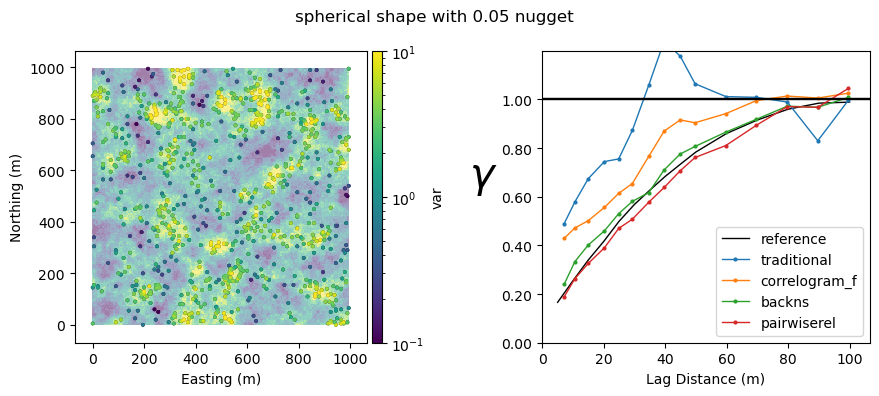

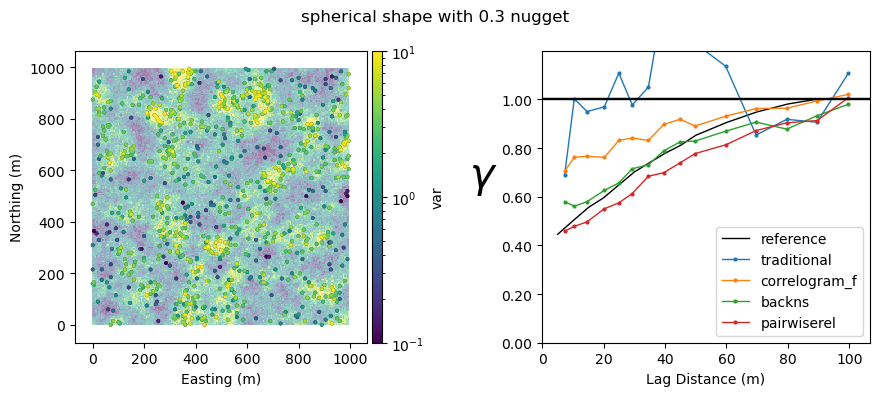

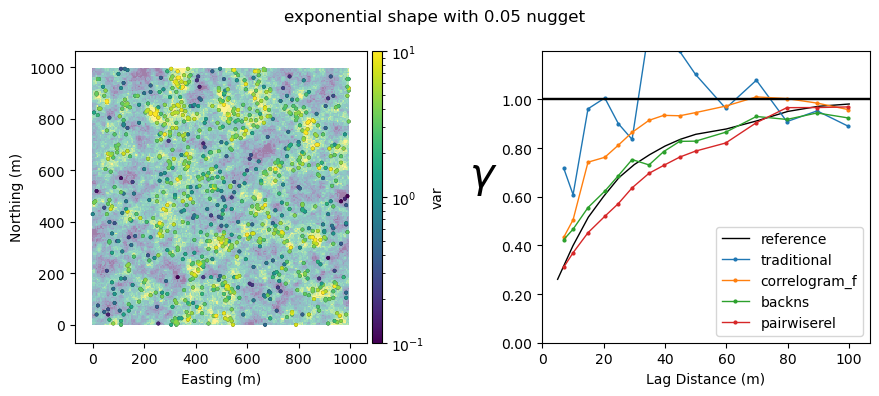

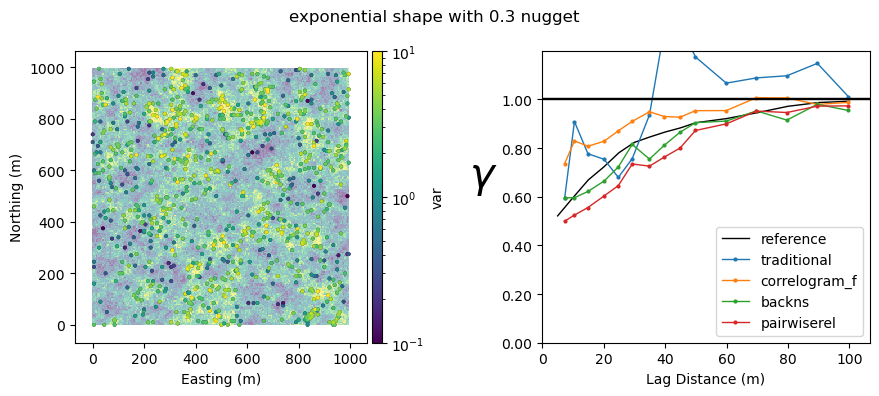

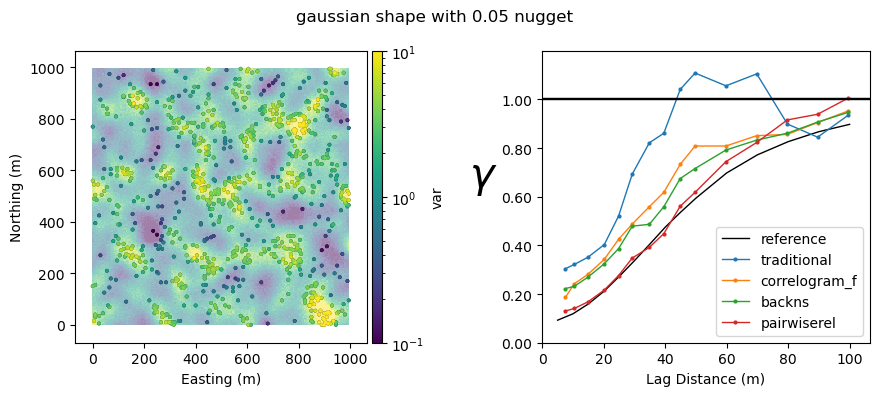

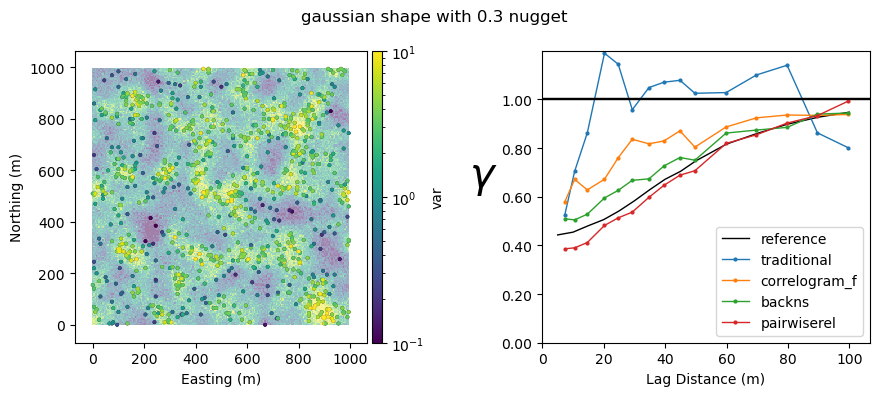

In [14]:
for shape in ['spherical', 'exponential', 'gaussian']:
    for nugget in [0.05, 0.3]:
        figtitle = f'{shape} shape with {nugget} nugget'
        tabname = f'{shape[:3]},{nugget} nugg'
        vario_pars = dict(
            nugget=nugget, shapes=shape, var_contribs=1-nugget,
            angles=[0, 0, 0], ranges=[100, 100, 1], num_struct=1)
        generate_reference(figtitle, vario_pars)

---

<footer>
<div style="text-align:center">    
    <p style="text-align:center; color:#00797C"> Partners: </p>
    <a href="https://resourcemodelingsolutions.com"><img class="rs" style="max-width:200px;"    src="https://geostatisticslessons.com/images/icons/resource_modeling_solutions_logo.png">
    </a>
    <a  href="https://geostatisticslessons.com/termsofuse"> <p style="text-align:center; color:#00797C">  Terms of Use </p></a>
    <a href="mailto:contact@resmodsol.com"> <p style="text-align:center; color:#00589d">Contact Resource Modeling Solutions about a commercial or academic license for RMSP</p> </a>
</div>
</footer>